# Predictive Risk Modeling → Personalized Policy


In [2]:
# =============================
# 0) Imports & Data Load
# =============================
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

from IPython.display import display

# Plot styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Connect & load
conn = duckdb.connect('../bree_case_study.db')
df = conn.execute("SELECT * FROM v_canonical_risk_model").df()
print("Shape:", df.shape)
df.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Shape: (6536, 56)


,loan_id,user_id,loan_amount,is_first_loan,requested_at_utc,approved_at_utc,disbursed_at_utc,due_date_clean,repaid_at_utc,tip_amount,...,balance_to_outflow_14d,balance_to_outflow_30d,balance_to_inflow_14d,balance_to_inflow_30d,hist_repay_rate,hist_default_rate,hist_default_count,hist_avg_late_days,hist_avg_late_days_count,default_30d
0,L578-2,578,174.59,0,2025-07-17 20:00:00-04:00,2025-07-19 00:52:21.209098-04:00,2025-07-19 14:04:04.032518-04:00,2025-08-02,NaT,0.0,...,-11.468893,-5.979984,-5.867977,-2.427714,1.0,0.0,0.0,0.0,0.0,1
1,L2192-1,2192,105.92,1,2025-03-27 20:00:00-04:00,2025-03-27 22:09:23.000581-04:00,2025-03-28 06:23:28.218050-04:00,2025-04-11,2025-04-14 06:23:28.218050-04:00,0.0,...,-7.239019,-3.212593,-3.351063,-3.156512,NaN,NaN,NaN,NaN,NaN,0
2,L8707-1,8707,114.10,1,2025-06-14 20:00:00-04:00,2025-06-15 07:26:07.452814-04:00,2025-06-15 14:52:24.265400-04:00,2025-06-29,2025-06-29 14:52:24.265400-04:00,0.0,...,-2.437220,-1.735496,-2.494095,-1.336176,NaN,NaN,NaN,NaN,NaN,0
3,L108-3,108,199.66,1,2025-07-15 20:00:00-04:00,2025-07-16 00:00:35.795007-04:00,2025-07-16 01:19:31.128107-04:00,2025-07-30,2025-07-30 01:19:31.128107-04:00,0.0,...,-9.790084,-5.744854,-4.531400,-2.658501,NaN,NaN,NaN,NaN,NaN,0
4,L928-2,928,108.60,1,2025-06-03 20:00:00-04:00,2025-06-04 17:19:16.651226-04:00,2025-06-04 19:43:25.594476-04:00,2025-06-18,2025-06-20 19:43:25.594476-04:00,0.0,...,-8.534592,-5.278997,-2.623067,-2.968376,NaN,NaN,NaN,NaN,NaN,0


In [3]:
# =============================
# 1) Build Feature List Dynamically
# =============================

target = "default_30d"

# Columns to drop (IDs, timestamps, outcomes, leakage features, economics)
drop_cols = [
    target,              # label
    # leakage features
    "loan_id", "user_id",
    "requested_at_utc", "approved_at_utc", "disbursed_at_utc",
    "due_date_clean", "repaid_at_utc",
    "fee", "tip_amount", "instant_transfer_fee",
    "status",
    "loan_amount"
]

# Keep only columns that exist in this df
drop_cols = [c for c in drop_cols if c in df.columns]

# Dynamic feature list = everything else
feature_cols = [c for c in df.columns if c not in drop_cols]

print("Features used:", feature_cols)

# Build feature matrix
X_raw = df[feature_cols].copy()
y = df[target].astype(int)

# One-hot encode categoricals
X = pd.get_dummies(X_raw, drop_first=True)

# Clean up infinities / nulls
from sklearn.impute import SimpleImputer
# Replace inf/-inf with NaN first
X = X.replace([np.inf, -np.inf], np.nan)

# Median imputation
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

print("Final feature count:", X.shape[1])


Features used: ['is_first_loan', 'autopay_enrolled', 'device_os', 'province', 'acquisition_channel', 'signup_month', 'baseline_risk_score', 'risk_score_decile', 'payroll_frequency', 'fico_band', 'median_payroll_gap_days', 'payroll_frequency_bucket', 'days_since_last_payroll', 'inflow_cv_30d', 'total_inflow_30d', 'avg_eod_balance_14d', 'min_balance_14d', 'overdraft_days_14d', 'avg_eod_balance_30d', 'overdraft_days_30d', 'inflow_sum_14d', 'outflow_sum_14d', 'total_outflow_30d', 'outflow_to_inflow_14d', 'outflow_to_inflow_30d', 'rent_share_30d', 'essentials_share_14d', 'discretionary_share_14d', 'essentials_share_30d', 'discretionary_share_30d', 'net_cf_momentum_14d', 'net_cf_momentum_30d', 'inflow_volatility_14d', 'inflow_volatility_30d', 'balance_to_outflow_14d', 'balance_to_outflow_30d', 'balance_to_inflow_14d', 'balance_to_inflow_30d', 'hist_repay_rate', 'hist_default_rate', 'hist_default_count', 'hist_avg_late_days', 'hist_avg_late_days_count']
Final feature count: 64


In [4]:

# =============================
# 2) Train / Test Split
# =============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape, y_train.mean().round(3), y_test.mean().round(3))



(4575, 64) (1961, 64) 0.253 0.252


In [5]:
# =============================
# 3) Logistic Regression (L1 / LASSO) with CV
# =============================
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Candidate C values (inverse of regularization strength)
C_values = np.logspace(-3, 1, 9)  # e.g. [0.001 ... 10]

lasso_cv = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegressionCV(
        Cs=C_values,
        penalty="l1",
        solver="saga",
        cv=5,                # 5-fold cross-validation
        scoring="roc_auc",
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    ))
])

# Train
lasso_cv.fit(X_train, y_train)

# Best regularization strength
best_C = float(lasso_cv.named_steps["clf"].C_[0])
print("Best C:", best_C)

# Feature coefficients
coef = pd.Series(lasso_cv.named_steps["clf"].coef_[0], index=X_train.columns)

# Keep only non-zero features
kept = coef[coef != 0].sort_values(ascending=False)
if kept.empty:
    print("No features selected (all coefficients shrunk to 0).")
else:
    print("Non-zero features (top 20):")
    display(kept.head(20))
    print(f"Kept {kept.size} / {coef.size} features")


Best C: 0.01
Non-zero features (top 20):


baseline_risk_score    0.156076
risk_score_decile      0.056902
dtype: float64

Kept 2 / 64 features


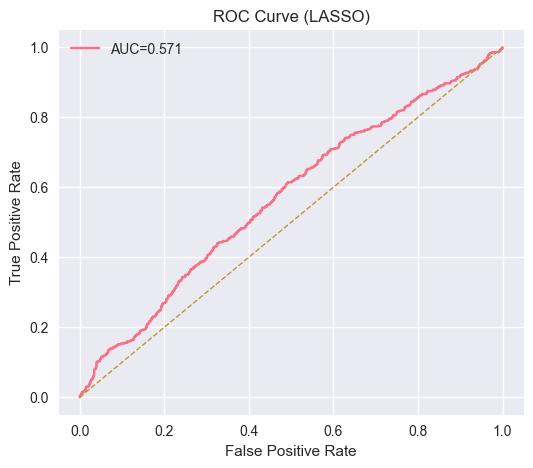

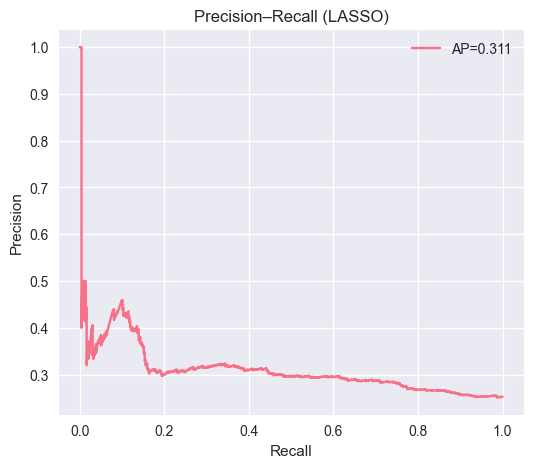

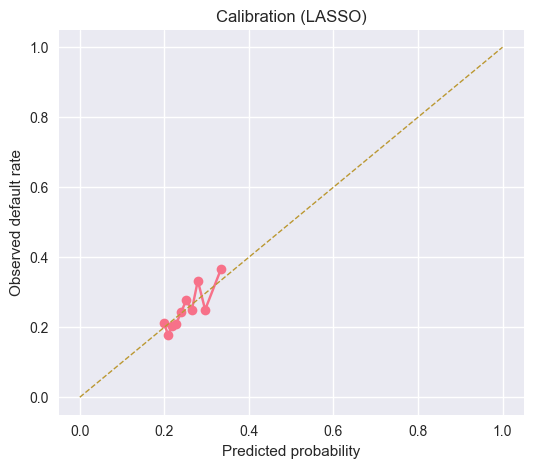

AUC=0.571  |  AP=0.311  |  Brier=0.186  |  LogLoss=0.559


In [6]:
# =============================
# 4) Evaluation: ROC, PR, Calibration
# =============================
from sklearn.metrics import brier_score_loss, log_loss

from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_pred_prob = lasso_cv.predict_proba(X_test)[:, 1]

# AUC / ROC
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LASSO)")
plt.legend()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (LASSO)")
plt.legend()
plt.show()

# Calibration
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy="quantile")
# Calibration metrics
brier = brier_score_loss(y_test, y_pred_prob)
ll = log_loss(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration (LASSO)")
plt.show()




print(f"AUC={auc:.3f}  |  AP={ap:.3f}  |  Brier={brier:.3f}  |  LogLoss={ll:.3f}")


Stability by province:


,province,n_samples,AUC,AP
4,ON,714,0.597,0.355
5,QC,455,0.567,0.342
1,BC,288,0.564,0.300
0,AB,229,0.534,0.229
2,MB,85,0.445,0.287
6,SK,64,0.541,0.237
3,NS,51,0.617,0.148


Stability by device_os:


,device_os,n_samples,AUC,AP
1,ios,1013,0.550,0.290
0,android,948,0.591,0.338


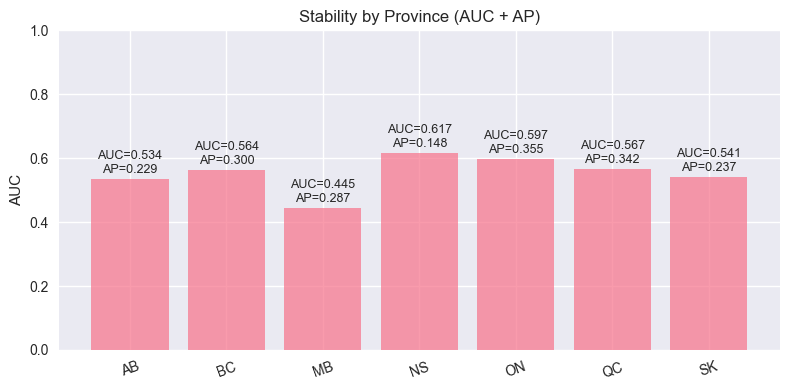

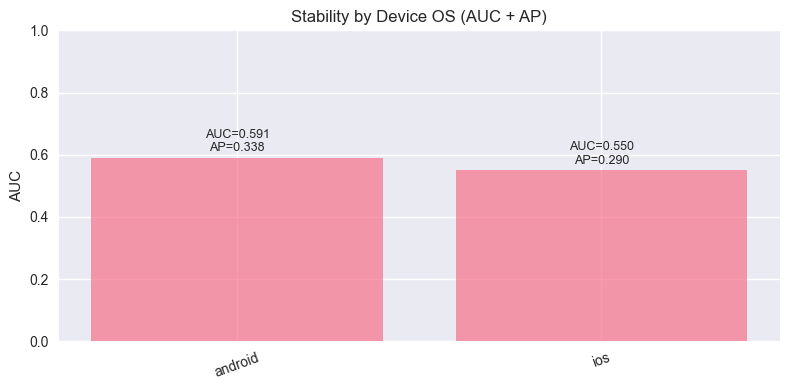

In [11]:
# =============================
# 5) Stability across segments + plots
# =============================
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

# Align test rows back to original df for segment columns
df_test = df.loc[X_test.index].copy()

def eval_segment(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    return auc, ap

def evaluate_stability(df_seg, y_true, y_prob, segment_col, min_n=50):
    rows = []
    for seg in sorted(df_seg[segment_col].dropna().unique()):
        mask = (df_seg[segment_col] == seg)
        if mask.sum() < min_n:
            continue
        auc, ap = eval_segment(y_true[mask], y_prob[mask])
        rows.append({segment_col: seg, "n_samples": int(mask.sum()),
                     "AUC": round(auc, 3), "AP": round(ap, 3)})
    return pd.DataFrame(rows)

stab_prov = evaluate_stability(df_test, y_test, y_pred_prob, "province")
stab_os   = evaluate_stability(df_test, y_test, y_pred_prob, "device_os")

print("Stability by province:")
display(stab_prov.sort_values("n_samples", ascending=False))
print("Stability by device_os:")
display(stab_os.sort_values("n_samples", ascending=False))

# --- Plots with metrics in labels ---
def bar_with_metrics(df_res, cat_col, title):
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.bar(df_res[cat_col].astype(str), df_res["AUC"], alpha=0.7)
    for i, (auc, ap) in enumerate(zip(df_res["AUC"], df_res["AP"])):
        ax1.text(i, auc + 0.01, f"AUC={auc:.3f}\nAP={ap:.3f}", ha='center', va='bottom', fontsize=9)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("AUC")
    ax1.set_title(title)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

bar_with_metrics(stab_prov, "province", "Stability by Province (AUC + AP)")
bar_with_metrics(stab_os, "device_os", "Stability by Device OS (AUC + AP)")


,name,threshold,approval_rate,def_rate_approved,def_rate_declined,sensitivity,specificity,precision
0,Fixed Approval 30%,0.223153,0.299847,0.198980,0.275310,0.763636,0.321282,0.275310
1,Fixed Approval 35%,0.226876,0.349822,0.193878,0.283922,0.731313,0.377217,0.283922
2,Fixed Approval 40%,0.234711,0.399796,0.200255,0.287171,0.682828,0.427694,0.287171
3,Fixed Default ≤ 19%,0.197321,0.031107,0.180328,0.254737,0.977778,0.034106,0.254737
4,Fixed Default ≤ 25%,0.354236,0.982152,0.249740,0.400000,0.028283,0.985675,0.400000
5,Fixed Default ≤ 30%,1.000000,1.000000,0.252422,NaN,0.000000,1.000000,NaN


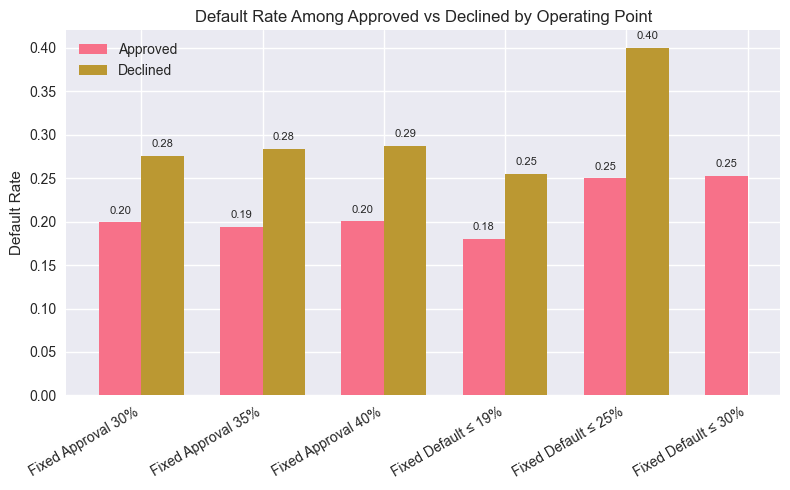

In [12]:
# =============================
# 6) Operating Points: fixed approvals & fixed default targets
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_point(y_true, y_prob, threshold, name):
    """Return metrics dict for a given threshold."""
    pred = (y_prob >= threshold).astype(int)  # 1 = decline, 0 = approve
    tn, fp, fn, tp = confusion_matrix(y_true, pred, labels=[0,1]).ravel()

    approved = (y_prob < threshold)
    declined = ~approved

    return {
        "name": name,
        "threshold": threshold,
        "approval_rate": approved.mean(),
        "def_rate_approved": y_true[approved].mean() if approved.any() else np.nan,
        "def_rate_declined": y_true[declined].mean() if declined.any() else np.nan,
        "sensitivity": tp / (tp + fn) if (tp + fn) > 0 else np.nan,
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else np.nan,
        "precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan
    }

results = []

# A) Fixed approval rates
approval_targets = [0.30, 0.35, 0.40]
for ta in approval_targets:
    t = float(np.quantile(y_pred_prob, ta))
    results.append(evaluate_point(y_test, y_pred_prob, t, f"Fixed Approval {int(ta*100)}%"))

# B) Fixed default targets
default_targets = [0.19, 0.25, 0.30]
candidates = np.r_[np.unique(y_pred_prob), 1.0]

for td in default_targets:
    best = None
    for t in candidates:
        approved = (y_pred_prob < t)
        if not approved.any():
            continue
        def_rate = y_test[approved].mean()
        if def_rate <= td:
            appr = approved.mean()
            if (best is None) or (appr > best[1]) or (appr == best[1] and t > best[0]):
                best = (float(t), float(appr), float(def_rate))
    if best:
        t_star, appr_star, def_star = best
        results.append(evaluate_point(
            y_test, y_pred_prob, t_star,
            f"Fixed Default ≤ {int(td*100)}%"
        ))

# Convert to dataframe
df_results = pd.DataFrame(results)
display(df_results)

# =============================
# Plot: Default rate among approved vs declined
# =============================
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(df_results))
width = 0.35

ax.bar(x - width/2, df_results["def_rate_approved"], width, label="Approved")
ax.bar(x + width/2, df_results["def_rate_declined"], width, label="Declined")

# Add numbers on bars
for i, v in enumerate(df_results["def_rate_approved"]):
    ax.text(i - width/2, v+0.01, f"{v:.2f}", ha="center", fontsize=8)
for i, v in enumerate(df_results["def_rate_declined"]):
    ax.text(i + width/2, v+0.01, f"{v:.2f}", ha="center", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(df_results["name"], rotation=30, ha="right")
ax.set_ylabel("Default Rate")
ax.set_title("Default Rate Among Approved vs Declined by Operating Point")
ax.legend()
plt.tight_layout()
plt.show()


In [28]:
# =============================
# Assign loan amounts by quantiles (among approved only)
# =============================

loan_buckets = [50, 100, 150, 200]  # 4 buckets

def assign_buckets(df, approve_col):
    """Assign loan amounts by PD quantile among approved loans only."""
    df = df.copy()
    mask = df[approve_col] == 1
    if mask.sum() > 0:
        # assign quantile-based buckets only to approved loans
        df.loc[mask, "loan_amount_assigned"] = pd.qcut(
            df.loc[mask, "PD"],
            q=len(loan_buckets),
            labels=loan_buckets
        ).astype(int)
    else:
        df["loan_amount_assigned"] = np.nan
    return df

# Apply to both approval policies
df_fixed35  = assign_buckets(df_policy, "approve_fixed35")
df_def19    = assign_buckets(df_policy, "approve_def19")

# =============================
# Compute PnL by bucket
# =============================

def compute_pnl(df, policy_name):
    LGD = 0.85
    APR = 0.12
    
    revenue = (df["fee"].fillna(0)
               + df["tip_amount"].fillna(0)
               + df["instant_transfer_fee"].fillna(0))
    amount  = df["loan_amount_assigned"].fillna(0)
    
    expected_loss = df["PD"] * amount * LGD
    proc_cost     = 0.3 + 0.012 * amount
    cap_cost      = (APR/365.0) * amount * df["days_outstanding"]
    
    df["exp_profit"] = revenue - expected_loss - proc_cost - cap_cost
    
    # Summaries by bucket
    bucket_summary = (
        df.groupby("loan_amount_assigned")
          .agg(
              n_loans=("loan_id", "count"),
              approval_rate=(policy_name, "mean"),
              default_rate=("default_30d", "mean"),
              avg_profit=("exp_profit", "mean"),
              total_profit=("exp_profit", "sum")
          )
          .reset_index()
          .sort_values("loan_amount_assigned")
    )
    bucket_summary["policy"] = policy_name
    
    return bucket_summary

summary_fixed35 = compute_pnl(df_fixed35, "approve_fixed35")
summary_def19   = compute_pnl(df_def19, "approve_def19")

summary_all = pd.concat([summary_fixed35, summary_def19], ignore_index=True)

display(summary_all)


,loan_amount_assigned,n_loans,approval_rate,default_rate,avg_profit,total_profit,policy
0,50.0,574,1.0,0.188153,-8.576729,-4923.042368,approve_fixed35
1,100.0,570,1.0,0.177193,-18.578329,-10589.647541,approve_fixed35
2,150.0,570,1.0,0.203509,-29.199496,-16643.712699,approve_fixed35
3,200.0,572,1.0,0.187063,-40.601144,-23223.854479,approve_fixed35
4,50.0,601,1.0,0.184692,-8.592333,-5163.992426,approve_def19
5,100.0,597,1.0,0.185930,-18.636277,-11125.857618,approve_def19
6,150.0,601,1.0,0.194676,-29.232370,-17568.654542,approve_def19
7,200.0,596,1.0,0.194631,-40.860375,-24352.783709,approve_def19


In [31]:
# Row-level dataframe with loan_id, PD, and approval flag from approve_fixed35
loan_summary = df_fixed35[["loan_id", "PD", "approve_fixed35"]].copy()

# Rename PD to prob_default for clarity
loan_summary = loan_summary.rename(columns={"PD": "prob_default",
                                            "approve_fixed35": "approval_flag"})

loan_summary.to_csv("risk_score.csv", index=False)


In [33]:
conn.close()